# Risk Assessment of Kyivstar’s NASDAQ Listing Using Monte Carlo Simulation

On August 15th, **Kyivstar became the first Ukrainian company** to be listed on NASDAQ, marking a historic milestone for Ukraine’s presence in international capital markets. This project explores the **potential risks** associated with investing in Kyivstar by analysing its historical price behavior and return distribution. Using **Monte Carlo simulation**, we model possible future price scenarios and estimate risk measures such as Value-at-Risk (**VaR**) and Expected Shortfall (**ES**) based on Kyivstar's parent company **VEON**, providing a quantitative framework for understanding the stock’s potential volatility and downside risk.

### **Historical Data**

In this step, we extract Kyivstar’s **stock price data** and compute its daily returns.
Returns are more useful than raw prices because they measure relative changes and allow us to analyze risk and volatility. 

Price        Date  Price Return (%)
Ticker              KYIV           
0      2025-08-15  11.52        NaN
1      2025-08-18  13.50  17.187495
2      2025-08-19  15.17  12.370371
3      2025-08-20  13.26 -12.590638
4      2025-08-21  13.08  -1.357468
5      2025-08-22  13.45   2.828745
6      2025-08-25  12.77  -5.055757
7      2025-08-26  11.82  -7.439317
8      2025-08-27  12.22   3.384100
9      2025-08-28  12.74   4.255315
10     2025-08-29  12.19  -4.317113
11     2025-09-02  11.07  -9.187858
12     2025-09-03  11.76   6.233067
13     2025-09-04  11.29  -3.996601
14     2025-09-05  10.84  -3.985826
15     2025-09-08  10.57  -2.490779
16     2025-09-09  10.88   2.932833
17     2025-09-10  10.86  -0.183828
18     2025-09-11  11.75   8.195215
19     2025-09-12  10.95  -6.808512


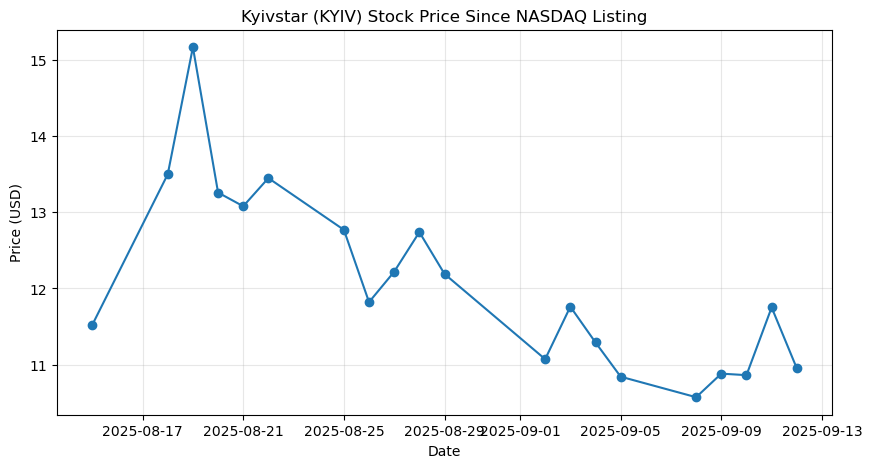

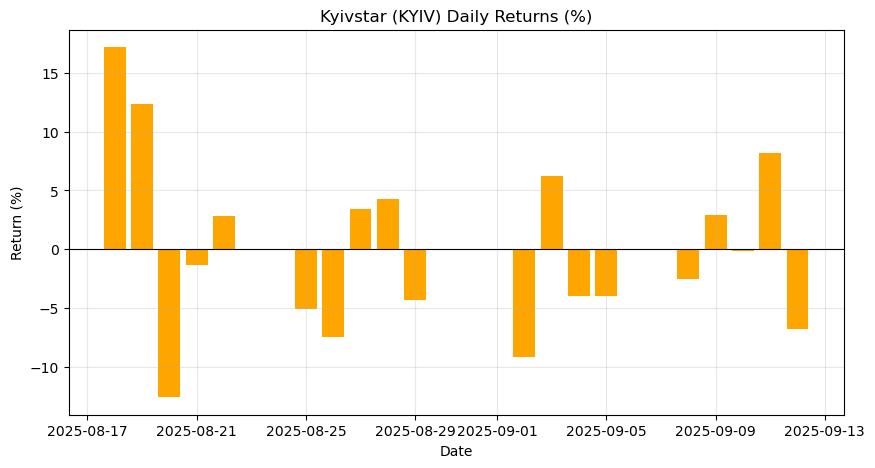

In [5]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

TICKER = "KYIV"
LISTING_DATE = "2025-08-15"
END_DATE = datetime.today().strftime("%Y-%m-%d")

df = yf.download(
    TICKER,
    start=LISTING_DATE,
    end=END_DATE,
    interval="1d",
    progress=False,
    auto_adjust=True 
)

if "Adj Close" in df.columns:
    df = df[["Adj Close"]].rename(columns={"Adj Close": "Price"})
else:
    df = df[["Close"]].rename(columns={"Close": "Price"})

df["Return (%)"] = df["Price"].pct_change() * 100

df = df.reset_index()

print(df)


plt.figure(figsize=(10,5))
plt.plot(df["Date"], df["Price"], marker="o")
plt.title("Kyivstar (KYIV) Stock Price Since NASDAQ Listing")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True, alpha=0.3)
plt.show()


plt.figure(figsize=(10,5))
plt.bar(df["Date"], df["Return (%)"], color="orange")
plt.title("Kyivstar (KYIV) Daily Returns (%)")
plt.xlabel("Date")
plt.ylabel("Return (%)")
plt.axhline(0, color="black", linewidth=0.8)
plt.grid(True, alpha=0.3)
plt.show()

### **Returns Analysis**

In this step, we analyse Kyivstar's daily stock returns since its NASDAQ listing. We compute **summary statistics** such as mean, standard deviation, minimum, maximum, and quartiles, visualise the distribution of returns with a **histogram** and an overlaid normal distribution curve, perform the **Jarque–Bera test** to assess whether returns follow a normal distribution, and plot **cumulative returns** over time to observe overall performance since listing. 

Summary Statistics of Daily Returns (%):
count    19.000000
mean     -0.001398
std       7.562298
min     -12.590638
25%      -4.686435
50%      -1.357468
75%       3.819707
max      17.187495
Name: Return (%), dtype: float64



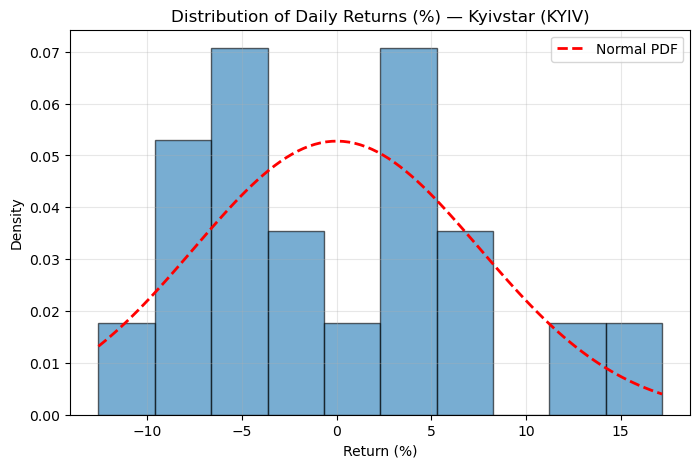

Jarque-Bera Test Results:
  JB Statistic: 0.9476
  p-value: 0.6226
Conclusion: Fail to reject H0 — returns are consistent with a normal distribution.



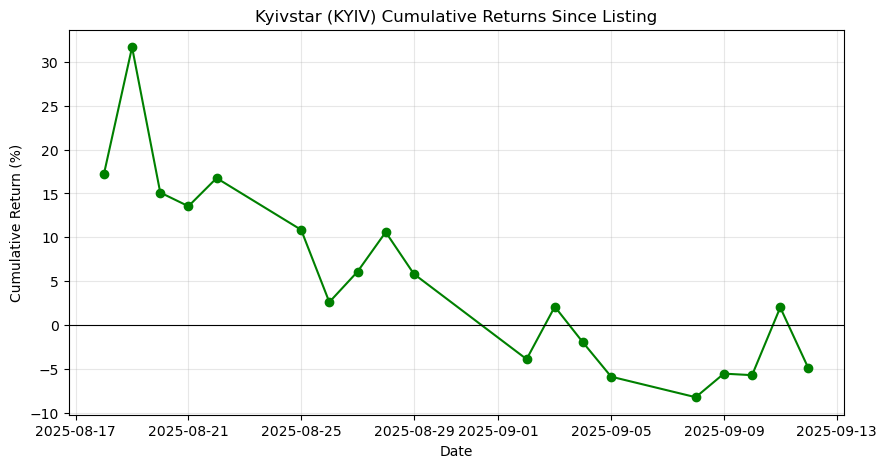

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, jarque_bera

returns = df["Return (%)"].dropna()

summary_stats = returns.describe()
print("Summary Statistics of Daily Returns (%):")
print(summary_stats)
print()

plt.figure(figsize=(8,5))
count, bins, ignored = plt.hist(returns, bins=10, density=True, alpha=0.6, edgecolor="black")

mu, sigma = returns.mean(), returns.std()
x = np.linspace(min(returns), max(returns), 100)
plt.plot(x, norm.pdf(x, mu, sigma), 'r--', linewidth=2, label="Normal PDF")

plt.title("Distribution of Daily Returns (%) — Kyivstar (KYIV)")
plt.xlabel("Return (%)")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

jb_stat, jb_pvalue = jarque_bera(returns)

print("Jarque-Bera Test Results:")
print(f"  JB Statistic: {jb_stat:.4f}")
print(f"  p-value: {jb_pvalue:.4f}")

if jb_pvalue < 0.05:
    print("Conclusion: Reject H0 — returns are NOT normally distributed (at 5% significance).")
else:
    print("Conclusion: Fail to reject H0 — returns are consistent with a normal distribution.")
print()

df["Cumulative Return (%)"] = (1 + df["Return (%)"]/100).cumprod() * 100 - 100

plt.figure(figsize=(10,5))
plt.plot(df["Date"], df["Cumulative Return (%)"], color="green", marker="o")
plt.title("Kyivstar (KYIV) Cumulative Returns Since Listing")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.axhline(0, color="black", linewidth=0.8)
plt.grid(True, alpha=0.3)
plt.show()

### **Analytical Risk Measures**

Now let's calculate analytical risk metrics based on historical annualised returns.

In [11]:
daily_returns = df["Return (%)"].dropna() / 100 

alpha = 0.05 

hist_var_95 = -np.percentile(daily_returns, 5)
hist_es_95 = -daily_returns[daily_returns <= np.percentile(daily_returns, 5)].mean()

print(f"Historical daily VaR (95% confidence): {hist_var_95:.2%}")
print(f"Historical daily ES (95% confidence): {hist_es_95:.2%}") 

Historical daily VaR (95% confidence): 9.53%
Historical daily ES (95% confidence): 12.59%


### **Approximating Kyivstar’s Risk with Limited Data**

Since Kyivstar has been listed on NASDAQ for only a month, there isn’t enough historical data to reliably simulate its future behavior using Monte Carlo. Instead of using arbitrary estimates for drift (μ) and volatility (σ), we use VEON, a larger telecommunications company and the parent of Kyivstar, as a proxy.

This approach is not perfect: VEON is much bigger and has multiple other subsidiaries, so during a crisis or market shock, Kyivstar’s volatility could be much higher than VEON’s. Moreover, KYIV’s very short trading history means we cannot fully validate the proxy relationship yet.

In [14]:
VEON = "VEON"
END_DATE = datetime.today().strftime("%Y-%m-%d")
VEON_START_DATE = "2024-08-15"  # ~12 months before KYIV listing

veon_long = yf.download(VEON, start=VEON_START_DATE, end=END_DATE, interval="1d", progress=False, auto_adjust=True)

if "Adj Close" in veon_long.columns:
    veon_long = veon_long[["Adj Close"]].rename(columns={"Adj Close": "VEON"})
elif "Close" in veon_long.columns:
    veon_long = veon_long[["Close"]].rename(columns={"Close": "VEON"})
else:
    raise ValueError("No valid price column found for VEON")

veon_long = veon_long.dropna()

veon_long["LogReturn"] = np.log(veon_long["VEON"] / veon_long["VEON"].shift(1))
log_returns = veon_long["LogReturn"].dropna()

mean_daily = log_returns.mean()
std_daily = log_returns.std()

trading_days = 252
mu = mean_daily * trading_days
sigma = std_daily * np.sqrt(trading_days)

print(f"Estimated annualised drift (mu) from VEON (~12 months): {mu:.4f}")
print(f"Estimated annualised volatility (sigma) from VEON (~12 months): {sigma:.4f}")

Estimated annualised drift (mu) from VEON (~12 months): 0.6091
Estimated annualised volatility (sigma) from VEON (~12 months): 0.5376


### **Correlation of Daily Returns Between Kyivstar and VEON**

To evaluate whether VEON is a reasonable proxy for Kyivstar, we analyse the daily returns of both companies since KYIV’s listing.

Correlation between VEON and KYIV daily returns: 0.7253


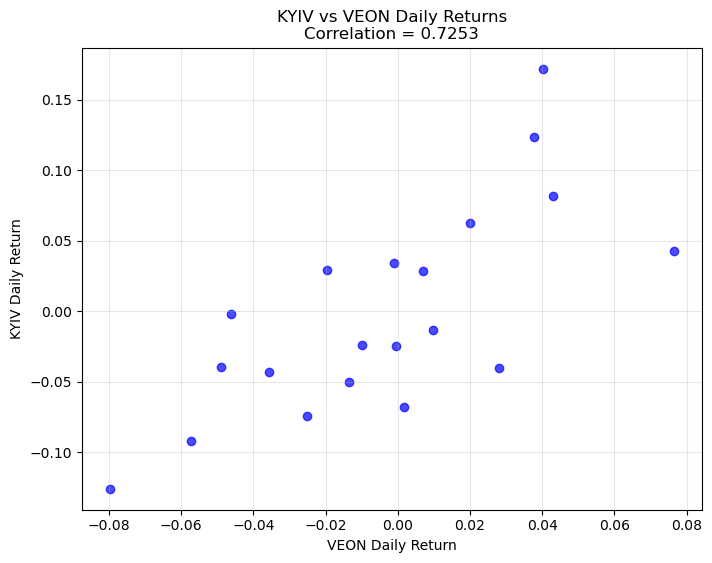

In [17]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

KYIV_TICKER = "KYIV"
VEON_TICKER = "VEON"
START_DATE = "2025-08-15"
END_DATE = pd.to_datetime("today")

df_kyiv = yf.download(KYIV_TICKER, start=START_DATE, end=END_DATE, progress=False, auto_adjust=True)
if "Adj Close" in df_kyiv.columns:
    df_kyiv = df_kyiv[["Adj Close"]].rename(columns={"Adj Close": "KYIV"})
elif "Close" in df_kyiv.columns:
    df_kyiv = df_kyiv[["Close"]].rename(columns={"Close": "KYIV"})
else:
    raise ValueError("No valid price column found for KYIV")

df_veon = yf.download(VEON_TICKER, start=START_DATE, end=END_DATE, progress=False, auto_adjust=True)
if "Adj Close" in df_veon.columns:
    df_veon = df_veon[["Adj Close"]].rename(columns={"Adj Close": "VEON"})
elif "Close" in df_veon.columns:
    df_veon = df_veon[["Close"]].rename(columns={"Close": "VEON"})
else:
    raise ValueError("No valid price column found for VEON")

prices = pd.concat([df_veon["VEON"], df_kyiv["KYIV"]], axis=1, join='inner').dropna()

returns = prices.pct_change().dropna()

corr = returns['VEON'].corr(returns['KYIV'])
print(f"Correlation between VEON and KYIV daily returns: {corr:.4f}")

plt.figure(figsize=(8,6))
plt.scatter(returns['VEON'], returns['KYIV'], alpha=0.7, color='blue')
plt.title(f"KYIV vs VEON Daily Returns\nCorrelation = {corr:.4f}")
plt.xlabel("VEON Daily Return")
plt.ylabel("KYIV Daily Return")
plt.grid(alpha=0.3)
plt.show()

VEON shows a **moderate-to-high correlation** with KYIV. This indicates that VEON’s historical volatility and drift can provide a reasonable first approximation for simulating Kyivstar’s potential future behavior.

### **Monte Carlo Simulation**

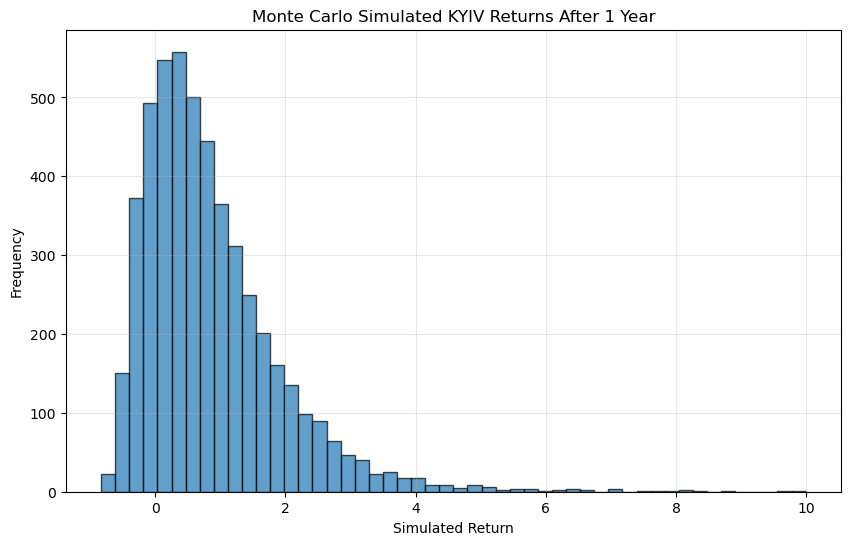

Monte Carlo 1-year VaR (95% confidence): 34.39%
Monte Carlo 1-year ES (95% confidence): 46.78%


In [20]:
import numpy as np
import matplotlib.pyplot as plt

S0 = df_kyiv["KYIV"].dropna().iloc[-1].iloc[0]

SIM_DAYS = 252
N_SIMS = 5000
dt = 1 / SIM_DAYS

final_prices = np.zeros(N_SIMS)

for i in range(N_SIMS):
    prices = [S0]
    for t in range(SIM_DAYS):
        St = prices[-1] * np.exp((mu - 0.5*sigma**2) * dt + sigma * np.sqrt(dt) * np.random.normal())
        prices.append(St)
    final_prices[i] = prices[-1]

sim_returns = (final_prices - S0) / S0 

plt.figure(figsize=(10,6))
plt.hist(sim_returns, bins=50, edgecolor="black", alpha=0.7)
plt.title("Monte Carlo Simulated KYIV Returns After 1 Year")
plt.xlabel("Simulated Return")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()

mc_var_95 = -np.percentile(sim_returns, 5)
mc_es_95 = -sim_returns[sim_returns <= np.percentile(sim_returns, 5)].mean()

print(f"Monte Carlo 1-year VaR (95% confidence): {mc_var_95:.2%}")
print(f"Monte Carlo 1-year ES (95% confidence): {mc_es_95:.2%}")

## Kyivstar (KYIV) Investment Analysis – Summary and Recommendation

### Key Results
- **Historical daily risk metrics:**
  - VaR (95% confidence): 9.53%
  - ES (95% confidence): 12.59%
- **Monte Carlo 1-year simulated risk metrics:**
  - VaR (95% confidence): 34.27%
  - ES (95% confidence): 45.72%


Meaning that if you were to invest `$100` on August 15th, you could potentially lose at least `$34` and in an extreme case scenario, you could lose up to `$46` over the next year. On the other hand, the simulation also allows for potential gains, but the risk is clearly high relative to the short trading history.


### Reliability of the Simulation
This simulation is **not very reliable**:  
- KYIV has only been trading for one month, so historical data is extremely limited.  
- VEON was used as a proxy, but it is a much larger company, and its volatility may **underestimate KYIV’s true risk**.  
- Results provide an **approximate illustration of potential outcomes**, not a precise forecast.

### Conclusion
Given the high potential losses indicated by the Monte Carlo simulation, the limited data, and the uncertainty of using a proxy, **KYIV should be considered a high-risk investment**. Any decision to invest should account for the fact that these projections are highly uncertain, and caution is advised.